# Task1: Evaluation of enhanced baseline Transformer based + Tfidf model

In [ ]:
!pip install transformers torch

In [ ]:
! cp -r /content/drive/MyDrive/synthetic-squad .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/synthetic-squad/src')
os.getcwd()

'/content/drive/MyDrive/synthetic-squad/src'

In [ ]:
import sklearn
from sklearn.metrics import classification_report
from transformers import AutoModel
import pandas as pd
from utils import get_data_task1
from bert_tfidf import *

import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

import joblib

In [ ]:
TASK = 3
DPATH = r'/content/drive/MyDrive/synthetic-squad/data/liwc_pos_dep_eval.csv'
D2PATH = r'/content/drive/MyDrive/synthetic-squad/data/liwc_pos_dep_reddit.csv'
MPATH = "roberta-base"

df_aa_paper = pd.read_csv(DPATH)

df_reddit = pd.read_csv(D2PATH)

label2id = {'human': 0,
 'fair': 1,
 'grover': 2,
 'gpt2': 3,
 'gpt3': 4,
 'instructgpt': 5,
 'gpt': 6,
 'ctrl': 7,
 'pplm': 8,
 'xlnet': 9,
 'xlm': 10}

In [ ]:
class BERT_TFIDF_Classifier(nn.Module):
    def __init__(self, bert_model, num_classes, tfidf_size):
        super(BERT_TFIDF_Classifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + tfidf_size, num_classes)

    def forward(self, input_ids, attention_mask, tfidf_vector):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #import ipdb;ipdb.set_trace()
        pooled_output = bert_output.pooler_output
        concatenated = torch.cat([pooled_output, tfidf_vector], dim=1)
        dropped = self.dropout(concatenated)
        logits = self.classifier(dropped)
        return logits


In [ ]:
def load_model(model_path, labels2id, test_features, model_name="roberta-base"):
  pretrained_model = AutoModel.from_pretrained(model_name)
  concat_model = BERT_TFIDF_Classifier(pretrained_model, num_classes=len(labels2id), tfidf_size=test_features.shape[1])
  concat_model = nn.DataParallel(concat_model)
  
  concat_model.load_state_dict(torch.load(model_path))
  return concat_model


In [ ]:
def pred_from_transformer(test_df, reddit_df, labels2id, model_path, vectorizer_path, liwc_features=None, model_name="roberta-base"):
  vectorizer = joblib.load(vectorizer_path)
  test_dataloader, reddit_dataloader = data_batcher_evaluate(test_df, reddit_df, vectorizer, labels2id, batch_size=32, model_name=model_name, numerical_fields=liwc_features)
  test_features = get_features_test(test_df, vectorizer, numerical_fields=liwc_features)
  model = load_model(model_path, labels2id, test_features)

  # For AA PAPER
  pred, true_label = evaluate_test(model, test_dataloader, labels2id, test_df["alg"])

  # For Reddit
  # reddit_predict = predict_labels(model, reddit_dataloader, labels2id, reddit_df["alg"])

  return pred, true_label

In [ ]:
def print_metric_task1(pred_df, label2id, model_path, vectorizer_path, liwc_features=None, source="aa_paper", batch_size=20):
  df_source = pred_df[pred_df["src"] == source]
  eval_df = get_data_task1(df_source, 20)
  idx_set = set(eval_df.first_idx.to_list() + eval_df.second_idx.to_list())
  filtered_df = pred_df[pred_df.index.isin(idx_set)]

  preds, true_label = pred_from_transformer(filtered_df, filtered_df, label2id, model_path, vectorizer_path, liwc_features)
  # indices = [i[0].reshape(len(i[0]), 1) for i in preds]
  # pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

  # filtered_df["pred"] = np.vstack(pred_labels)
  filtered_df["pred"] = preds

  id2label = {id: alg for alg, id in label2id.items()}

  eval_df["pred_labels"] = eval_df[["first_idx", "second_idx"]].apply(lambda x: (filtered_df.loc[x[0]]['pred'], filtered_df.loc[x[1]]['pred']), axis=1)
  eval_df["pred"] = eval_df["pred_labels"].apply(lambda x: "Same" if x[0] == x[1] else "Not Same")
  

  print(classification_report(eval_df["ground_truth"], eval_df["pred"]))

  # example ground truth and predictions
  y_true = eval_df["ground_truth"].to_list()
  y_pred = eval_df["pred"].to_list()

  # create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # plot the confusion matrix
  classes = ["Same", "Not Same"]
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return eval_df



/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00        20
        fair       1.00      0.91      0.95        22
         gpt       1.00      1.00      1.00        20
        gpt2       0.85      0.94      0.89        18
        gpt3       0.90      0.75      0.82        24
      grover       0.95      0.95      0.95        20
       human       0.95      1.00      0.97        19
 instructgpt       0.70      0.93      0.80        15
        pplm       1.00      0.95      0.98        21
         xlm       1.00      1.00      1.00        20
       xlnet       1.00      0.95      0.98        21

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.95      0.94      0.94       220



<ipython-input-9-42d166b152a5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.99      0.99      0.99     22000
        Same       0.89      0.90      0.89      2090

    accuracy                           0.98     24090
   macro avg       0.94      0.94      0.94     24090
weighted avg       0.98      0.98      0.98     24090



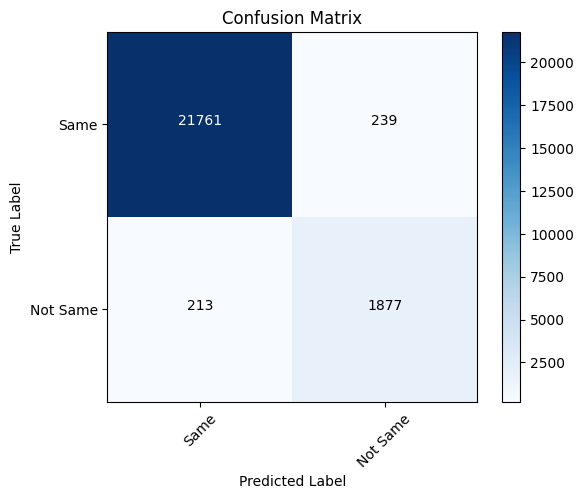

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,463,1197,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,463,764,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,463,133,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,463,1026,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,463,587,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,1207,1262,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,1207,760,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,990,1262,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,990,760,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos/checkpoint_epoch=3-val_loss=0.17280692871039113.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos/vectorizer.pkl")

/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

        gpt3       0.90      0.72      0.80        25
      grover       0.00      0.00      0.00         1
       human       0.25      1.00      0.40         5
 instructgpt       0.65      0.45      0.53        29

    accuracy                           0.60        60
   macro avg       0.45      0.54      0.43        60
weighted avg       0.71      0.60      0.62        60

              precision    recall  f1-score   support

    Not Same       0.80      0.70      0.74      1200
        Same       0.49      0.62      0.55       570

    accuracy                           0.67      1770
   macro avg       0.64      0.66      0.65      1770
weighted avg       0.70      0.67      0.68      1770



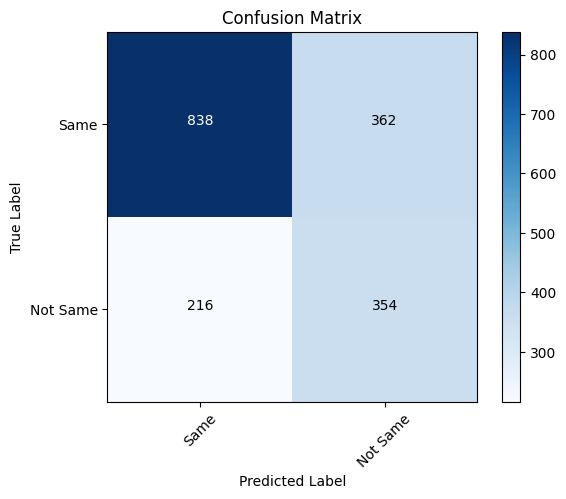

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1564,1442,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
1,1564,1098,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
2,1564,1456,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
3,1564,1727,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
4,1564,1236,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
...,...,...,...,...,...,...
1765,2522,2254,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1766,2522,2368,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1767,2393,2254,"(instructgpt, instructgpt)",Same,"(gpt3, instructgpt)",Not Same
1768,2393,2368,"(instructgpt, instructgpt)",Same,"(gpt3, gpt3)",Same


In [ ]:
print_metric_task1(df_reddit, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos/checkpoint_epoch=3-val_loss=0.17280692871039113.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos/vectorizer.pkl", source="reddit")

/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

        ctrl       1.00      0.95      0.98        21
        fair       1.00      0.95      0.98        21
         gpt       1.00      0.91      0.95        22
        gpt2       1.00      1.00      1.00        20
        gpt3       0.95      0.59      0.73        32
      grover       0.95      0.95      0.95        20
       human       1.00      1.00      1.00        20
 instructgpt       0.35      0.88      0.50         8
        pplm       0.85      1.00      0.92        17
         xlm       0.95      1.00      0.97        19
       xlnet       1.00      1.00      1.00        20

    accuracy                           0.91       220
   macro avg       0.91      0.93      0.91       220
weighted avg       0.95      0.91      0.92       220



<ipython-input-9-42d166b152a5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.99      0.98      0.99     22000
        Same       0.84      0.90      0.87      2090

    accuracy                           0.98     24090
   macro avg       0.92      0.94      0.93     24090
weighted avg       0.98      0.98      0.98     24090



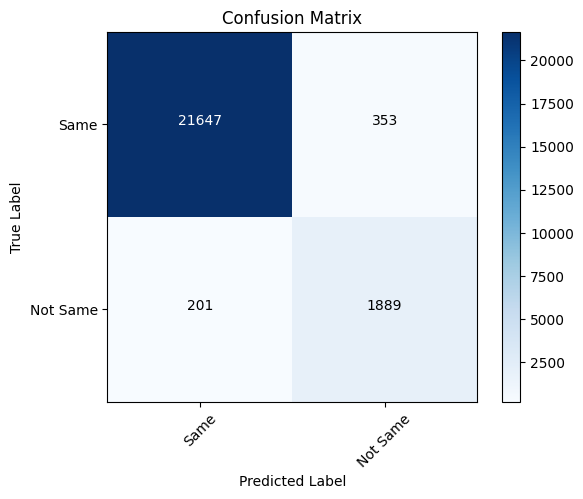

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,592,962,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,592,1145,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,592,908,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,592,16,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,592,865,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,654,663,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,654,386,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,366,663,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,366,386,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos_dep/checkpoint_epoch=2-val_loss=0.21201472314229855.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos_dep/vectorizer.pkl")

/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

         gpt       0.00      0.00      0.00         1
        gpt3       1.00      0.71      0.83        28
      grover       0.00      0.00      0.00         1
       human       0.40      1.00      0.57         8
 instructgpt       0.60      0.55      0.57        22

    accuracy                           0.67        60
   macro avg       0.40      0.45      0.40        60
weighted avg       0.74      0.67      0.67        60

              precision    recall  f1-score   support

    Not Same       0.81      0.77      0.79      1200
        Same       0.56      0.63      0.59       570

    accuracy                           0.72      1770
   macro avg       0.69      0.70      0.69      1770
weighted avg       0.73      0.72      0.73      1770



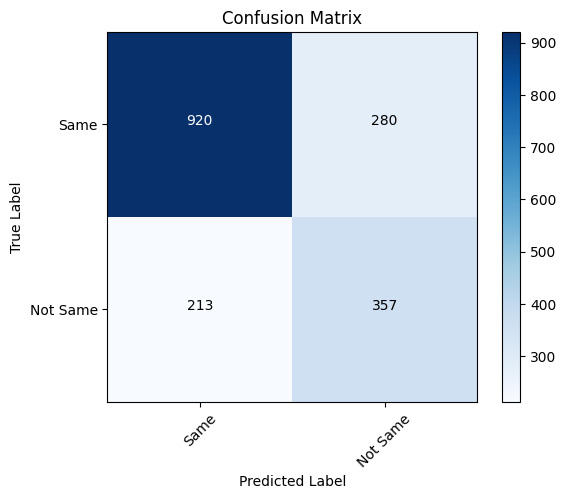

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1040,1195,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
1,1040,1763,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
2,1040,1498,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
3,1040,1232,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
4,1040,1767,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
...,...,...,...,...,...,...
1765,2275,2171,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1766,2275,2406,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1767,2009,2171,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1768,2009,2406,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same


In [ ]:
print_metric_task1(df_reddit, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos_dep/checkpoint_epoch=2-val_loss=0.21201472314229855.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos_dep/vectorizer.pkl", source="reddit")

/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00        20
        fair       0.95      0.95      0.95        20
         gpt       1.00      1.00      1.00        20
        gpt2       1.00      0.95      0.98        21
        gpt3       0.90      0.72      0.80        25
      grover       0.90      1.00      0.95        18
       human       1.00      0.95      0.98        21
 instructgpt       0.65      0.87      0.74        15
        pplm       1.00      1.00      1.00        20
         xlm       0.95      1.00      0.97        19
       xlnet       1.00      0.95      0.98        21

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.95      0.94      0.94       220



<ipython-input-15-56c2ff29551c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.99      0.99      0.99     22000
        Same       0.89      0.90      0.90      2090

    accuracy                           0.98     24090
   macro avg       0.94      0.95      0.94     24090
weighted avg       0.98      0.98      0.98     24090



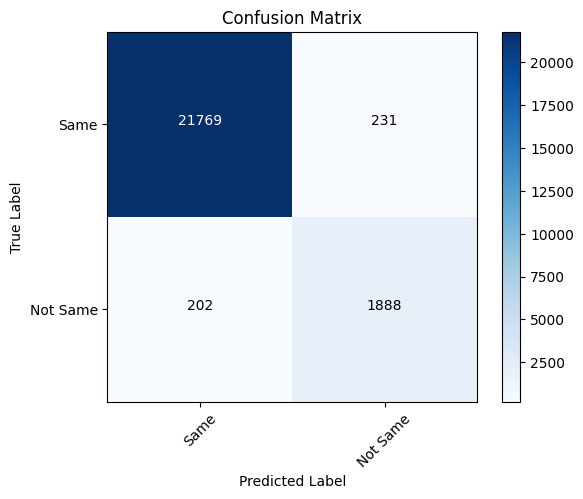

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,930,201,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,930,550,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,930,29,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,930,773,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,930,890,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,243,254,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,243,1269,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,918,254,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,918,1269,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos_dep_liwc/checkpoint_epoch=4-val_loss=0.16928044552332722.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos_dep_liwc/vectorizer.pkl", liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])

/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["alg_id"] = test_data["alg"].apply(lambda x: labels2id[x])
/content/drive/MyDrive/synthetic-squad/src/bert_tfidf.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data["alg_id"] = reddit_data["alg"].apply(lambda x: labels2id[x])
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight',

              precision    recall  f1-score   support

        gpt3       0.95      0.59      0.73        32
      grover       0.00      0.00      0.00         1
       human       0.40      1.00      0.57         8
 instructgpt       0.35      0.37      0.36        19

    accuracy                           0.57        60
   macro avg       0.43      0.49      0.42        60
weighted avg       0.67      0.57      0.58        60

              precision    recall  f1-score   support

    Not Same       0.80      0.71      0.75      1200
        Same       0.51      0.62      0.56       570

    accuracy                           0.68      1770
   macro avg       0.65      0.67      0.66      1770
weighted avg       0.70      0.68      0.69      1770



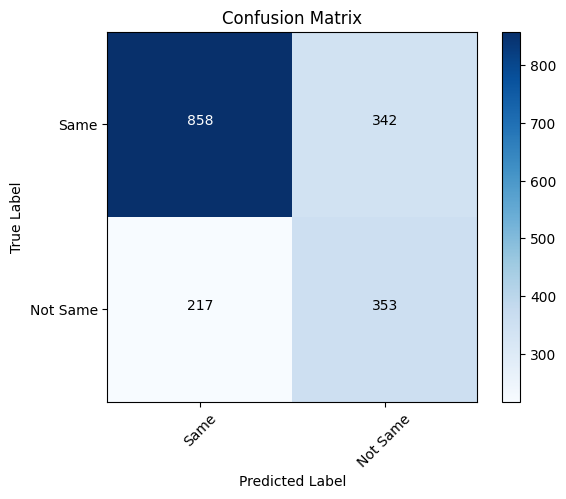

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1065,1549,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
1,1065,1608,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
2,1065,1116,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
3,1065,1261,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
4,1065,1105,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
...,...,...,...,...,...,...
1765,2425,2259,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1766,2425,1948,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1767,2638,2259,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1768,2638,1948,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same


In [ ]:
print_metric_task1(df_reddit, label2id, "/content/drive/MyDrive/synthetic-squad/models_state/roberta_base_pos_dep_liwc/checkpoint_epoch=4-val_loss=0.16928044552332722.ckpt", "/content/drive/MyDrive/synthetic-squad/models/roberta_base_pos_dep_liwc/vectorizer.pkl", liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"], source="reddit")